In [1]:
import pandas as pd
import geopandas as gpd
import glob

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "patch.force_edgecolor" on line 33 in
/home/christian/.miniconda2/envs/datacourse/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "lines.dashed_pattern" on line 18 in
/home/christian/.miniconda2/envs/datacourse/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "boxplot.meanprops.markeredgecolor" on line 369 in
/home/christian/.miniconda2/envs/datacourse/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotli

### Load Data

In [2]:
trips = pd.read_excel("data/EXCEL/UNLINKED_Public.xlsx")
taz = gpd.read_file("data/BPM_TAZ2010.shp")

In [3]:
pd.options.display.max_columns = None

In [4]:
COUNTIES_TAZ = {1: "Manhattan",
                2: "Queens",
                3: "Bronx",
                4: "Brooklyn",
                5: "Staten Island"}
nyc_taz = taz[taz['REGION'] == 1].reset_index(drop=True)
nyc_taz["COUNTY"] = nyc_taz["COUNTYCODE"].apply(lambda x: COUNTIES_TAZ[x])
nyc_taz.head()

,ID,AREA,AREA1,TAZ_ID1,BPZ3_ID,REGION,COUNTYCODE,geometry,COUNTY
0,1009,0.196601,0.196601,1009,3257,1,3,"POLYGON ((-73.8236 40.89089999999999, -73.8235...",Bronx
1,903,0.551513,0.551513,903,3151,1,3,"POLYGON ((-73.921145 40.887094, -73.9207009999...",Bronx
2,901,0.100066,0.100066,901,3149,1,3,"POLYGON ((-73.9041 40.9083, -73.9036 40.9099, ...",Bronx
3,902,0.194815,0.194815,902,3150,1,3,POLYGON ((-73.90649999999999 40.90159999999999...,Bronx
4,900,0.169347,0.169347,900,3148,1,3,"POLYGON ((-73.9084 40.8993, -73.90729999999999...",Bronx


In [5]:
trips["OTAZ"]
trips_with_origin = trips.merge(nyc_taz, left_on="OTAZ", right_on="TAZ_ID1")
trips_with_od = trips_with_origin.merge(nyc_taz, left_on="DTAZ", right_on="TAZ_ID1", suffixes=("_O", "_D"))

In [6]:
to_manhattan = trips_with_od["COUNTY_D"] == "Manhattan"
from_manhattan = trips_with_od["COUNTY_O"] == "Manhattan"
manhattan_only = trips_with_od[to_manhattan | from_manhattan]
manhattan_gdf = gpd.GeoDataFrame(manhattan_only.reset_index(drop=True))
manhattan_gdf["geometry"] = manhattan_gdf["geometry_D"]

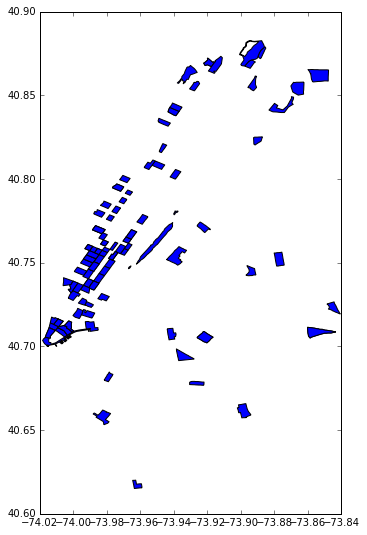

In [7]:
night_only = manhattan_gdf[(manhattan_gdf["TRP_DEP_HR"] < 6) | (manhattan_gdf["TRP_DEP_HR"] == 24 )]

# from travel survey docs
SUBWAY_MODE = 15
subway_night_trips = night_only[night_only["ULTMODE"] == SUBWAY_MODE]
survey_cols = ["PLSAM",  u'TRP_DEP_HR',
 u'TRP_ARR_HR',
 u'TRP_DEP_MIN',
 u'TRP_ARR_MIN',
 u'TRPDUR',]
subway_night_trips = subway_night_trips[survey_cols + list(subway_night_trips.columns[-12:])].reset_index(drop=True)
subway_night_trips.plot(figsize=(16, 9))

In [8]:
len(subway_night_trips)

114

#### Find likely subway path

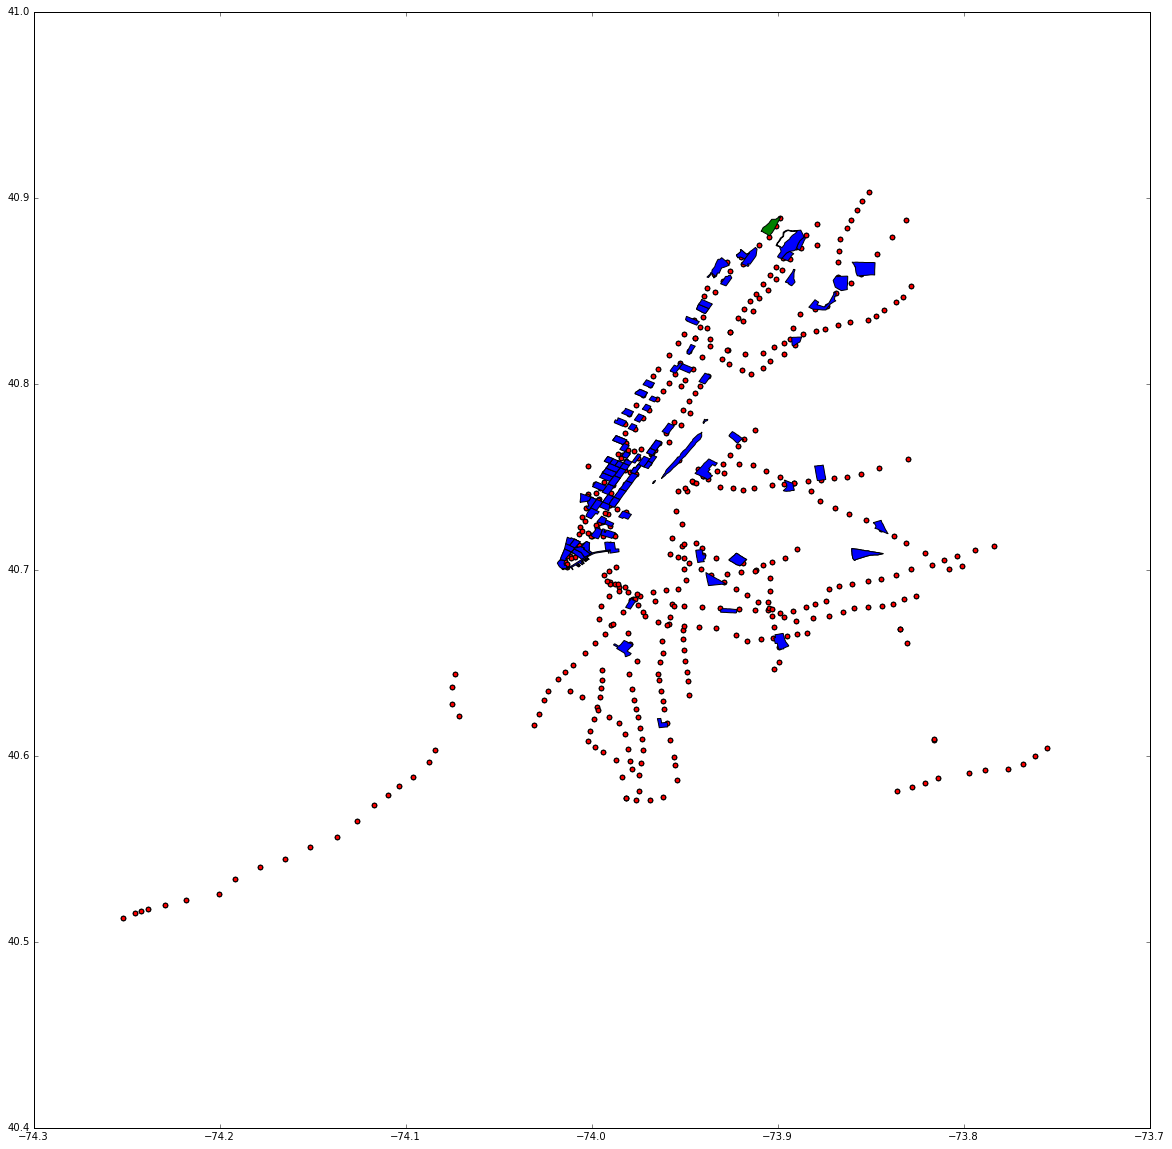

In [9]:
import shapely.geometry

stops = pd.read_csv("data/mta_gtfs/stops.txt")
stops["geometry"] = stops.apply(lambda x: shapely.geometry.Point((x["stop_lon"], x["stop_lat"])), axis=1)
stops = gpd.GeoDataFrame(stops)
ax = stops.plot(c='red', figsize=(20, 20))
subway_night_trips.plot(ax=ax)
stops["base_geom"] = stops["geometry"]
subway_night_trips["geometry"] = subway_night_trips["geometry_O"]
subway_night_trips[subway_night_trips["PLSAM"] == 41193320204].plot(ax=ax, color='green')

## TODO


1. Expand buffer zone to make sure every origin TAZ has a list of candidate stops

2. Repeat the code below to get destination candidates

In [10]:
old_stops = stops
stops = stops.dropna(subset=["parent_station"]).reset_index(drop=True)

subway_night_trips["geometry"] = subway_night_trips["geometry_O"]
stops["geometry"] = stops["base_geom"]
stops["buffered"] = stops.buffer(.002)
stops["geometry"] = stops["buffered"]
joined_o = gpd.sjoin(subway_night_trips, stops, op='intersects', how='left')\
              .reset_index(drop=True)
#ax = stops.plot(figsize=(16, 16))
no_candidate = joined_o["stop_lat"].isnull()
interesting = joined_o[no_candidate]

to_join = interesting[subway_night_trips.columns]
stops['geometry'] = stops['base_geom']
stops['buffered'] = stops.buffer(.003)
stops['geometry'] = stops['buffered']
expanded_buffer = gpd.sjoin(to_join, stops, op='intersects', how='left')
del joined_o["index_right"]
joined_o = joined_o[~no_candidate].reset_index(drop=True)
joined_o = pd.concat([joined_o, expanded_buffer]).reset_index(drop=True)
assert len(joined_o[joined_o["stop_lat"].isnull()]) == 0


joined_o["geometry"] = joined_o["geometry_D"]
stops["geometry"] = stops["base_geom"]
stops["buffered"] = stops.buffer(.002)
stops["geometry"] = stops["buffered"]

joined_d = gpd.sjoin(joined_o, stops, op='intersects', how='left', lsuffix="O", rsuffix="D").reset_index(drop=True)

#ax = stops.plot(figsize=(16, 16))
no_candidate = joined_d["stop_lat_D"].isnull()
interesting = joined_d[no_candidate]

to_join = interesting
del to_join["index_D"]
for c in stops.columns:
    del to_join[c + "_D"]
stops['geometry'] = stops['base_geom']
stops['buffered'] = stops.buffer(.0115)
stops['geometry'] = stops['buffered']
expanded_buffer = gpd.sjoin(to_join, stops, op='intersects', how='left', lsuffix="O", rsuffix="D")
stops_cols = set(stops.columns)
expanded_buffer.columns = [(c if c not in stops_cols else c + "_D") for c in expanded_buffer.columns]

expanded_buffer = expanded_buffer.reset_index(drop=True)
joined_d = joined_d[~no_candidate].reset_index(drop=True)
joined_d = pd.concat([joined_d, expanded_buffer]).reset_index(drop=True)
joined_d = joined_d.dropna(subset=["parent_station_D"])
assert len(joined_d[joined_d["stop_lat_D"].isnull()]) == 0
assert set(joined_o.PLSAM.unique()) - set(joined_d.PLSAM.unique()) == set()
assert set(subway_night_trips.PLSAM.unique()) - set(joined_o.PLSAM.unique()) == set()
stops = old_stops

In [11]:
joined_d[joined_d["PLSAM"] == 41193320204]

,AREA1_D,AREA_D,BPZ3_ID_D,COUNTYCODE_D,COUNTY_D,COUNTY_O,ID_D,PLSAM,REGION_D,TAZ_ID1_D,TRPDUR,TRP_ARR_HR,TRP_ARR_MIN,TRP_DEP_HR,TRP_DEP_MIN,base_geom_D,base_geom_O,buffered_D,buffered_O,geometry,geometry_D,geometry_O,index_D,index_right,location_type_D,location_type_O,parent_station_D,parent_station_O,stop_code_D,stop_code_O,stop_desc_D,stop_desc_O,stop_id_D,stop_id_O,stop_lat_D,stop_lat_O,stop_lon_D,stop_lon_O,stop_name_D,stop_name_O,stop_url_D,stop_url_O,zone_id_D,zone_id_O
964,0.066257,0.066257,1095,1,Manhattan,Bronx,93,41193320204,1,93,45,6,20.0,5,35.0,POINT (-73.98207600000001 40.746081),POINT (-73.90483399999999 40.878856),"POLYGON ((-73.98007600000001 40.746081, -73.98...","POLYGON ((-73.902834 40.878856, -73.9028436305...","POLYGON ((-73.978245 40.746614, -73.9787039999...","POLYGON ((-73.978245 40.746614, -73.9787039999...","POLYGON ((-73.8985 40.8901, -73.899 40.8892, -...",292.0,NaN,0.0,0.0,632,104,NaN,NaN,NaN,NaN,632N,104N,40.746081,40.878856,-73.982076,-73.904834,33 St,231 St,NaN,NaN,NaN,NaN
965,0.066257,0.066257,1095,1,Manhattan,Bronx,93,41193320204,1,93,45,6,20.0,5,35.0,POINT (-73.98207600000001 40.746081),POINT (-73.90483399999999 40.878856),"POLYGON ((-73.98007600000001 40.746081, -73.98...","POLYGON ((-73.902834 40.878856, -73.9028436305...","POLYGON ((-73.978245 40.746614, -73.9787039999...","POLYGON ((-73.978245 40.746614, -73.9787039999...","POLYGON ((-73.8985 40.8901, -73.899 40.8892, -...",293.0,NaN,0.0,0.0,632,104,NaN,NaN,NaN,NaN,632S,104N,40.746081,40.878856,-73.982076,-73.904834,33 St,231 St,NaN,NaN,NaN,NaN
966,0.066257,0.066257,1095,1,Manhattan,Bronx,93,41193320204,1,93,45,6,20.0,5,35.0,POINT (-73.984264 40.74307),POINT (-73.90483399999999 40.878856),"POLYGON ((-73.982264 40.74307, -73.98227363054...","POLYGON ((-73.902834 40.878856, -73.9028436305...","POLYGON ((-73.978245 40.746614, -73.9787039999...","POLYGON ((-73.978245 40.746614, -73.9787039999...","POLYGON ((-73.8985 40.8901, -73.899 40.8892, -...",295.0,NaN,0.0,0.0,633,104,NaN,NaN,NaN,NaN,633S,104N,40.743070,40.878856,-73.984264,-73.904834,28 St,231 St,NaN,NaN,NaN,NaN
967,0.066257,0.066257,1095,1,Manhattan,Bronx,93,41193320204,1,93,45,6,20.0,5,35.0,POINT (-73.984264 40.74307),POINT (-73.90483399999999 40.878856),"POLYGON ((-73.982264 40.74307, -73.98227363054...","POLYGON ((-73.902834 40.878856, -73.9028436305...","POLYGON ((-73.978245 40.746614, -73.9787039999...","POLYGON ((-73.978245 40.746614, -73.9787039999...","POLYGON ((-73.8985 40.8901, -73.899 40.8892, -...",294.0,NaN,0.0,0.0,633,104,NaN,NaN,NaN,NaN,633N,104N,40.743070,40.878856,-73.984264,-73.904834,28 St,231 St,NaN,NaN,NaN,NaN
968,0.066257,0.066257,1095,1,Manhattan,Bronx,93,41193320204,1,93,45,6,20.0,5,35.0,POINT (-73.98207600000001 40.746081),POINT (-73.90483399999999 40.878856),"POLYGON ((-73.98007600000001 40.746081, -73.98...","POLYGON ((-73.902834 40.878856, -73.9028436305...","POLYGON ((-73.978245 40.746614, -73.9787039999...","POLYGON ((-73.978245 40.746614, -73.9787039999...","POLYGON ((-73.8985 40.8901, -73.899 40.8892, -...",292.0,NaN,0.0,0.0,632,104,NaN,NaN,NaN,NaN,632N,104S,40.746081,40.878856,-73.982076,-73.904834,33 St,231 St,NaN,NaN,NaN,NaN
969,0.066257,0.066257,1095,1,Manhattan,Bronx,93,41193320204,1,93,45,6,20.0,5,35.0,POINT (-73.98207600000001 40.746081),POINT (-73.90483399999999 40.878856),"POLYGON ((-73.98007600000001 40.746081, -73.98...","POLYGON ((-73.902834 40.878856, -73.9028436305...","POLYGON ((-73.978245 40.746614, -73.9787039999...","POLYGON ((-73.978245 40.746614, -73.9787039999...","POLYGON ((-73.8985 40.8901, -73.899 40.8892, -...",293.0,NaN,0.0,0.0,632,104,NaN,NaN,NaN,NaN,632S,104S,40.746081,40.878856,-73.982076,-73.904834,33 St,231 St,NaN,NaN,NaN,NaN
970,0.066257,0.066257,1095,1,Manhattan,Bronx,93,41193320204,1,93,45,6,20.0,5,35.0,POINT (-73.984264 40.74307),POINT (-73.90483399999999 40.878856),"POLYGON ((-73.982264 40.74307, -73.98227363054...","POLYGON ((-73.902834 40.878856, -73.9028436305...","POLYGON ((-73.978245 40.746614, -73.9787039999...",

3. Develop the graph of the subway, where weights are distances between stops?

In [12]:
times = pd.read_csv("data/mta_gtfs/stop_times.txt")
trips = pd.read_csv("data/mta_gtfs/trips.txt")
transfers = pd.read_csv("data/mta_gtfs/transfers.txt")

In [13]:
times_with_line = times.merge(trips, on="trip_id")

In [14]:
import numpy as np
from datetime import datetime, time

basic = times_with_line.groupby(["route_id", "direction_id"]).first()["trip_id"].reset_index(drop=True)
weird = stops.merge(times_with_line, on="stop_id")
times_trip_indexed = times_with_line.set_index("trip_id")
basic_stop_ids = times_trip_indexed.loc[basic].stop_id.unique()
missing = weird[~weird["stop_id"].isin(basic_stop_ids)].stop_id.unique()

extra_trip_ids = times_with_line.groupby("stop_id").first().loc[missing].trip_id.reset_index(drop=True)
final_trip_ids = pd.concat([basic, extra_trip_ids]).reset_index(drop=True)
final_trips = times_trip_indexed.loc[final_trip_ids].reset_index()
final_trips["arrival_hour"] = final_trips["arrival_time"].apply(lambda x: int(x.split(":")[0]))
final_trips["arrival_minute"] = final_trips["arrival_time"].apply(lambda x: int(x.split(":")[1]))
final_trips["arrival_hour"].max()
final_trips["timestamp"] = final_trips.apply(lambda x: datetime.combine(datetime.now(), 
                                                                        time(x["arrival_hour"], 
                                                                             x["arrival_minute"])),
                                             axis=1)
final_trips["timestamp"].head()

0   2018-02-15 06:01:00
1   2018-02-15 06:04:00
2   2018-02-15 06:05:00
3   2018-02-15 06:06:00
4   2018-02-15 06:07:00
Name: timestamp, dtype: datetime64[ns]

In [15]:
final_trips["our_id"] = final_trips.apply(lambda x: x["stop_id"] + "-" + x["route_id"], axis=1)
final_trips["our_id"].head()
our_id_by_stop = final_trips.set_index("stop_id").our_id
stop_by_our_id = final_trips.drop_duplicates(subset=["our_id"]).set_index("our_id").stop_id

In [16]:
import networkx as nx
graph = nx.Graph()

In [17]:
for _, t in final_trips.groupby("trip_id"):
    prev_stop = None
    route = t.route_id.iloc[0]
    for _, stop in t.sort_values("stop_sequence").iterrows():
        if prev_stop is not None:
            diff = (stop["timestamp"] - prev_stop["timestamp"]).total_seconds()
            graph.add_edge(stop.our_id, prev_stop.our_id, attr_dict={"weight": diff})
        prev_stop = stop

In [18]:
fails = set()
for parent, stop_group in stops.dropna(subset=["parent_station"]).groupby("parent_station"):
    for _, s_1 in stop_group.iterrows():
        for _, s_2 in stop_group.iterrows():
            try:
                our_s_1 = our_id_by_stop.loc[s_1.stop_id]
                our_s_2 = our_id_by_stop.loc[s_2.stop_id]
            except KeyError:
                fails.add(s_1.stop_id)
                fails.add(s_2.stop_id)
                continue

            our_s_1 = our_s_1 if isinstance(our_s_1, pd.Series) else pd.Series([our_s_1])
            our_s_2 = our_s_2 if isinstance(our_s_2, pd.Series) else pd.Series([our_s_2])
            for our_1 in our_s_1:
                for our_2 in our_s_2:
                    graph.add_edge(our_1, our_2, attr_dict={"weight": 900.})

In [19]:
fails = list()
stops_parent_index = stops.set_index("parent_station")
for _, transfer in transfers.iterrows():
    from_stops = stops_parent_index.loc[transfer.from_stop_id]
    to_stops = stops_parent_index.loc[transfer.to_stop_id]
    try:
        our_from = our_id_by_stop.loc[from_stops.stop_id.as_matrix()]
        our_to = our_id_by_stop.loc[to_stops.stop_id.as_matrix()]
    except:
        fails.append(our_from)
        fails.append(our_to)
        
    for stop_1 in our_from:
        for stop_2 in our_to:
            graph.add_edge(stop_1, stop_2, attr_dict={"weight": 900.})

In [ ]:
# child_stops = stops.dropna(subset=["parent_station"]).stop_id.unique()
# from collections import defaultdict
# our_by_parent = defaultdict(set)
# for n in graph.nodes():
#     our_by_parent[n.split("-")[0]].add(n)

# for main, by_line in our_by_parent.iteritems():
#     for line in by_line:
#         graph.add_edge(main, line, attr_dict={"weight": 0.})

4. Dijkstra out each pair of origin/destination candidates

In [ ]:
# with_id = stops.set_index("stop_id")
# dudes = []
# for component_list in nx.algorithms.connected_components(graph):
#     try:
#         dudes.append(pd.DataFrame([with_id.loc[s] for s in component_list]))
#     except:
#         break
# dudes[7]

5. Take the one that is minimal overall travel distance, i suppose

In [24]:

grouped_ods = joined_d.groupby("PLSAM")
o = None
pairs = []
potentials = []
irrelevant = set(["140N", "140S"])
for gix, group in grouped_ods:
    min_distance = 9999999999
    shortest_path = None
    for _, item in group.iterrows():
        o_id = item.stop_id_O
        d_id = item.stop_id_D
        if o_id in irrelevant or d_id in irrelevant:
            continue
        o_potentials = our_id_by_stop.loc[o_id]
        d_potentials = our_id_by_stop.loc[d_id]
        o_potentials = o_potentials if isinstance(o_potentials, pd.Series) else pd.Series(o_potentials)
        d_potentials = d_potentials if isinstance(d_potentials, pd.Series) else pd.Series(d_potentials)
        for o_p in o_potentials:
            for d_p in d_potentials:      
                distance = nx.algorithms.dijkstra_path_length(graph, o_p,  d_p)
                if gix == 41193320204:
                    potentials.append((distance, nx.algorithms.dijkstra_path(graph, o_p,  d_p)))
                if distance < min_distance:
                    shortest_path = nx.algorithms.dijkstra_path(graph, o_p,  d_p)
                    min_distance = distance
                    
    pairs.append((gix, shortest_path, min_distance))
len(grouped_ods)

114

In [25]:
fixed = pd.DataFrame(pairs, columns=["PLSAM", "path", "total_seconds"])
fixed["stop_id_O"] = fixed["path"].apply(lambda x: stop_by_our_id.loc[x[0]])
fixed["stop_id_D"] = fixed["path"].apply(lambda x: stop_by_our_id.loc[x[-1]])

In [26]:
stop_by_our_id.loc["A51S-A"]

'A51S'

In [27]:
optimal_stops = joined_d.merge(fixed, on=["PLSAM", "stop_id_O", "stop_id_D"])
optimal_stops["num_stations"] = optimal_stops["path"].apply(len)

120.0


,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,geometry,base_geom
A22S,NaN,72 St,NaN,40.775594,-73.976410,NaN,NaN,0,A22,POINT (-73.97641 40.775594),POINT (-73.97641 40.775594)
A24S,NaN,59 St - Columbus Circle,NaN,40.768296,-73.981736,NaN,NaN,0,A24,POINT (-73.981736 40.768296),POINT (-73.981736 40.768296)


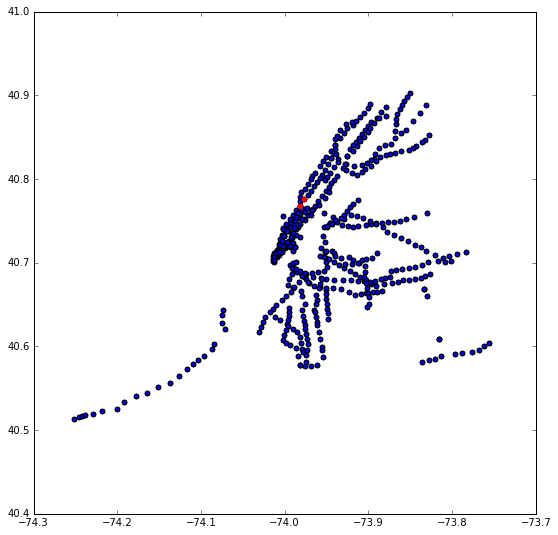

In [28]:
stops["geometry"] = stops["base_geom"]
stops_g = gpd.GeoDataFrame(stops).set_index("stop_id")
ax = stops_g.plot(figsize=(16, 9))
loc = 17
p = optimal_stops.iloc[loc]["path"]
things = []
for i, stop in enumerate(p):
    l = stops_g.loc[stop.split("-")[0]]
    things.append(l)
    mpmp = gpd.GeoDataFrame(l).swapaxes(0, 1)
    mpmp.plot(ax=ax, color='red')

print optimal_stops.iloc[loc]["total_seconds"]
pd.DataFrame(things)

,stop_name_O,stop_name_D,total_minutes,TRPDUR,minutes_diff,path
86,Fulton St,190 St,35.0,103,6.800000e+01,"[A38S-A, A36S-A, A34S-A, A32S-A, A31S-A, A28S-..."
58,51 St,Fulton St,16.0,60,4.400000e+01,"[630N-4, 631N-4, 632N-4, 633N-4, 634N-4, 635N-..."
19,Newkirk Av,59 St - Columbus Circle,51.0,83,3.200000e+01,"[246N-2, 245N-2, 244N-2, 243N-2, 242N-2, 241N-..."
43,Brooklyn Bridge - City Hall,68 St - Hunter College,18.0,50,3.200000e+01,"[640S-6X, 639S-6X, 638S-6X, 637S-6X, 636S-6X, ..."
11,116 St,34 St - Penn Station,15.0,45,3.000000e+01,"[A16S-C, A17S-C, A18S-C, A19S-C, A20S-C, A21S-..."
7,Sheepshead Bay,34 St - Herald Sq,36.0,59,2.300000e+01,"[D39N-B, D35N-B, D31N-B, D28N-B, D26N-B, D25N-..."
30,Sutphin Blvd,47-50 Sts - Rockefeller Ctr,28.0,50,2.200000e+01,"[F04N-F, F05N-F, F06N-F, F07N-F, G08N-F, G14N-..."
102,3 Av,Livonia Av,26.0,48,2.200000e+01,"[L05S-L, L06S-L, L08S-L, L10S-L, L11S-L, L12S-..."
55,34 St - Penn Station,Pelham Pkwy,43.0,65,2.200000e+01,"[128N-2, 127N-2, 126N-2, 125N-2, 124N-2, 123N-..."
112,47-50 Sts - Rockefeller Ctr,75 Av,23.0,43,2.000000e+01,"[D15N-F, B10N-F, B08N-F, B06N-F, B04N-F, G14N-..."


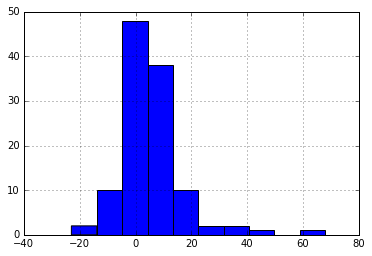

In [29]:
optimal_stops["total_minutes"] = ((optimal_stops["total_seconds"] / 60.))

optimal_stops["minutes_diff"] = (optimal_stops["TRPDUR"] - (optimal_stops["total_minutes"]))
optimal_stops["minutes_diff"].hist()
optimal_stops.sort_values("minutes_diff", ascending=False)[["stop_name_O", "stop_name_D", "total_minutes", "TRPDUR", "minutes_diff", "path"]]

In [30]:
rmse = np.sqrt(np.mean((optimal_stops["TRPDUR"] - optimal_stops["total_minutes"]) ** 2))
rmse

12.651884264353532

### Now cut off on manhattan stations

In [33]:
!wget -qnc -O data/nybb_18a.zip https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nybb_18a.zip
!cd data; unzip -oq nybb_18a.zip

In [34]:
boroughs = gpd.read_file("data/nybb_18a/nybb.shp")
manhattan_geo = boroughs[boroughs["BoroName"] == "Manhattan"]
stops["geometry"] = stops["base_geom"]
stops_with_borough = gpd.sjoin(stops, boroughs.to_crs(epsg=4326))

stops_in_manhattan = stops_with_borough.set_index("stop_id")

In [35]:
def filter_path(path):
    return [True if stops_in_manhattan.loc[p.split("-")[0]].BoroName == "Manhattan" else False for p in path]
def manhattan_stops(path):
    return [p for p in path if stops_in_manhattan.loc[p.split("-")[0]].BoroName == "Manhattan"]
def check_path(path):
    last_mn_index = -1
    for i, p in enumerate(path):
        if p and ((last_mn_index != (i-1)) and (last_mn_index != -1)):
            raise Exception(path)
        if p:
            last_mn_index = i
    return True
        
optimal_stops["in_manhattan"] = optimal_stops["path"].apply(filter_path)
optimal_stops["manhattan_path"] = optimal_stops["path"].apply(manhattan_stops)
optimal_stops["manhattan_geo"] = optimal_stops["manhattan_path"].apply(lambda x: [y.split("-")[0] for y in x])
optimal_stops["manhattan_len"] = optimal_stops["manhattan_path"].apply(len)

## SANITY CHECK
_ = optimal_stops["in_manhattan"].apply(check_path)

In [37]:
dump_fields = ["PLSAM", "TRP_ARR_HR", "TRP_ARR_MIN", "TRP_DEP_HR", "TRP_DEP_MIN", "TRPDUR", "stop_id_O", "stop_id_D", "path", "total_minutes", "manhattan_path", "manhattan_geo"]
out = optimal_stops[dump_fields]
out.to_csv("data/nycmtc_final_od.csv")
out.to_pickle("data/nycmtc_final_od.pkl")

## TODOS 2/13
- Run this for all trips, to potentially cover trips that go through manhattan as well?
- Histogram is still not great, but it's much better. COULD use nighttime schedules rather than the ones i'm specifically using

### Old code - used for census tract geo information (rather than NYMTC TAZ which is more granular)

In [ ]:
# stops["line_list"] = stops["line"].apply(lambda x: x.split("-"))
# stops.head()

In [ ]:
# tracts = pd.concat(gpd.read_file(f) for f in glob.glob("gz*.shp
# state_by_tract = {"36": "NY",
#                   "34": "NJ",
#                   "09": "CT"}
# trips_with_destination = trips.merge(tracts, left_on="DTRACT", right_on="clean_geo", how="left",
#                                      suffixes=("_d", "_d"))
# trips_with_od = trips_with_destination.merge(tracts, left_on="OTRACT", right_on="clean_geo", how="left", 
#                                              suffixes=("_o", "_d"))
# tracts["clean_geo"] = tracts.GEO_ID.apply(lambda x: int(x.split("US")[1]))
# trips_with_od["geometry"] = trips_with_od["geometry_o"]
# trips_o_geo = gpd.GeoDataFrame(trips_with_od)
# trips_o_geo[trips_o_geo["TRP_DEP_HR"] < 6].plot()
# len(trips_with_od[trips_with_od["TRP_DEP_HR"] < 5]


# manhattan_counties = {"061"}
# def o_or_d(row):
#     origin =  (row["COUNTY_o"] == "061")
#     destination = (row["COUNTY_d"] == "061")
#     if origin and not destination:
#         return "start"
#     if destination and not origin:
#         return "end"
#     if destination and origin:
#         return "both"
#     return "no"
# trips_o_geo["start_or_end"] = trips_o_geo[["COUNTY_o", "COUNTY_d"]].apply(o_or_d, axis=1)

# of_interest = trips_o_geo[((trips_o_geo["COUNTY_d"] == "061") | 
#                   (trips_o_geo["COUNTY_o"] == "061")) &
#                   (trips_o_geo["TRP_DEP_HR"] < 6)]

# all_subway_trips = trips_o_geo[trips_o_geo["ULTMODE"] == 15]
# interest_subway = of_interest[of_interest["ULTMODE"] == 15]
# len(interest_subway) / float(len(all_subway_trips))

# import matplotlib.pyplot as plt
# fig, axes = plt.subplots(1,  2, figsize=(16, 9))
# interest_subway["geometry"] = interest_subway["geometry_o"]
# interest_subway.plot('start_or_end', categorical=True, legend=True, ax=axes[0])

# interest_subway["geometry"] = interest_subway["geometry_d"]
# interest_subway.plot('start_or_end', categorical=True, legend=True, ax=axes[1])

# (interest_subway["start_or_end"].value_counts() / float(len(interest_subway)))

# import matplotlib
# %matplotlib inline


# areas_2010 = glob.glob("tl*.shp")
# areas_2010

# things = [gpd.read_file(s) for s in areas_2010]
# thing_1 = pd.concat(things)
# gdfs_2010 = gpd.GeoDataFrame(thing_1)

# ax = things[1].plot(figsize=(16, 9), color='red')
# ax = things[0].plot(ax=ax)
# ax = things[2].plot(ax=ax, color='green')

# things[0][things[0]["TAZCE10"].str.contains("2626")]

# trips.head()

In [ ]:
# stops_merged